In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import glob
import zipfile
import numpy as np
import statsmodels.api as sm
from collections import defaultdict, Counter
import networkx as nx

# Browsing Behaviors

In [2]:
import pandas as pd

taobao = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch//BrowsePurchase/1Userbrowsetime.csv',
                     names = ['time', 'user', 'item'])

In [3]:
taobao['hour'] = [int(i) for i in (taobao.time/3600)]
taobao['minute'] = [int(i) for i in (taobao.time/60)]

taobao = taobao.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [4]:
taobao[:3]

,time,user,item,hour,minute
341618,845,1,109,0,14
343061,846,1,109,0,14
347403,851,1,118,0,14


In [5]:
len(taobao)

32373278

In [7]:
taobao5k = taobao[taobao.user <=5000]
len(taobao5k)

324057

In [4]:
# taobao5k.to_csv("/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/taobao5k.txt", 
#                  index = False)

In [10]:
taobao5k[:10]

,time,user,item,hour,minute
341618,845,1,109,0,14
343061,846,1,109,0,14
347403,851,1,118,0,14
348269,852,1,115,0,14
348820,853,1,106,0,14
352991,858,1,108,0,14
354740,860,1,118,0,14
1341979,2207,1,107,0,36
2369665,3554,1,110,0,59
333412,836,3,147,0,13


In [3]:
import pandas as pd

taobao5k = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/taobao5k.txt')
taobao5k[:3]

,time,user,item,hour,minute
0,845,1,109,0,14
1,846,1,109,0,14
2,851,1,118,0,14


In [6]:
taobao1k = taobao5k[taobao5k.user <=1000]
len(taobao1k)

61583

In [26]:
dfg = taobao1k.groupby(['item']).size()
dfg = dfg.sort_values( ascending= 0)
dfg[:10]

item
14358    120
3030      81
3784      78
1377      76
165       66
18583     65
2408      62
590       60
3427      59
1078      58
dtype: int64

In [27]:
dfg_user = taobao1k.groupby(['item'])['user'].nunique().sort_values( ascending= 0)
dfg_user[:10]

item
243     35
1377    31
893     26
579     23
1621    23
2101    22
747     22
590     21
1163    21
874     20
Name: user, dtype: int64

In [29]:
dic_pvuv = defaultdict(list)
for i in dfg.index:
    dic_pvuv[i] = [ dfg[i], dfg_user[i] ]  

## Flow Network

In [9]:
taobao0 = taobao[taobao['hour']==0]
len(taobao0)

2421981

In [7]:
C = np.array(taobao1k[['user', 'item']])
len(C)

61583

In [8]:
from flownetwork import flownetwork as fn

In [9]:
g = fn.constructFlowNetwork(C)

In [10]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 30497\nNumber of edges: 54836\nAverage in degree:   1.7981\nAverage out degree:   1.7981'

In [119]:
h = fn.flowBalancing(g)

In [120]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [121]:
nx.info(h)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [122]:
edge_df = pd.DataFrame(h.edges(), columns = ['from', 'to'])
a = edge_df[edge_df['from']=='source']
len(a)

94613

In [123]:
a[:3]

,from,to
1334980,source,0
1334981,source,2
1334982,source,4


In [124]:
h['source'][0].values()[0]

3

In [11]:
aici = fn.getAICI(g)
aici.items()[:3]

[(0, [4.0, 62.836904017557814]),
 (1, [1.0, 21.708180543070306]),
 (2, [2.0, 28.729655806512806])]

In [21]:
ac_df = pd.DataFrame(aici.values(), index = aici.keys(),
                    columns = ['ai', 'ci'])

#ac_df.to_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/aici.txt')
ac_df[:3]

,ai,ci
0,4.0,62.836904
1,1.0,21.708181
2,2.0,28.729656


In [22]:
di = fn.networkDissipate(g)

In [23]:
fd = fn.flowDistanceFromSource(g)

In [25]:
di.items()[:3]

[(0, [0, 4, 0]), (1, [0, 2, 0]), (2, [5, 37, 7])]

In [24]:
toSink,totalflow,fromSource = np.array(di.values()).T

In [53]:
bdf=pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/1Userpurchasetime.csv', 
                names = ['time', 'user', 'item'])
dfi = bdf.groupby(['item']).size()
dfi = dfi.sort_values( ascending= 0)
dfi[:10]

item
3664     3598
3259     3015
1377     1941
884      1939
874      1839
2177     1833
97       1791
3423     1788
23138    1663
1235     1477
dtype: int64

In [57]:
dii = {}
for i in di:
    if i in dic_pvuv:
        try:
            sell = dfi[i]
        except:
            sell = 0
        dii[i]=[di[i][0], di[i][1], di[i][2], fd[i], aici[i][1], dic_pvuv[i][0], dic_pvuv[i][1], sell]

In [58]:
diif = pd.DataFrame(dii.values(), index = dii.keys(),
                    columns = ['dissipation','totalflow','fromSource', 'flowdistance', 'ci' , 'pv', 'uv', 'sell'])

diif = diif.sort_values('pv', ascending = False)
diif[:20]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell
14358,6,82,1,16.713977,447.211640,120,1,40
3030,3,19,11,3.338166,119.131295,81,15,241
3784,4,15,5,6.114829,108.547893,78,11,458
1377,9,64,20,7.181508,550.737683,76,31,1941
165,0,31,2,9.374617,323.974018,66,19,720
18583,1,25,1,10.157992,183.707837,65,2,22
2408,4,28,4,7.932782,162.844480,62,11,543
590,8,43,6,6.830182,302.548096,60,21,1099
3427,3,42,5,8.694083,299.255058,59,17,1268
1078,4,16,4,6.402240,103.092166,58,13,412


In [59]:
diif.to_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/diif.txt', 
             index = True)

In [65]:
diif = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/diif.txt', index_col = 0 )
diif[:10]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell
14358,6,82,1,16.713977,447.211640,120,1,40
3030,3,19,11,3.338166,119.131295,81,15,241
3784,4,15,5,6.114829,108.547893,78,11,458
1377,9,64,20,7.181508,550.737683,76,31,1941
165,0,31,2,9.374617,323.974018,66,19,720
18583,1,25,1,10.157992,183.707837,65,2,22
2408,4,28,4,7.932782,162.844480,62,11,543
590,8,43,6,6.830182,302.548096,60,21,1099
3427,3,42,5,8.694083,299.255058,59,17,1268
1078,4,16,4,6.402240,103.092166,58,13,412


In [66]:
diif['loop'] = diif['pv'] - diif['totalflow']

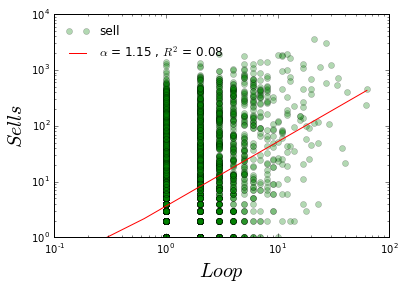

In [67]:
fn.alloRegressPlot(diif.loop,diif.sell,'g','o','$Loop$','$Sells$', loglog=True)


In [69]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)
diif['sell_log'] = np.log(diif.sell+1)


lm = smf.ols(formula='sell_log ~ pv_log + uv_log + fromSource_log + dissipation_log + ci_log + flowdistance',\
             data=diif).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:               sell_log   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     2765.
Date:                Tue, 06 Jun 2017   Prob (F-statistic):               0.00
Time:                        00:08:47   Log-Likelihood:                -49312.
No. Observations:               30495   AIC:                         9.864e+04
Df Residuals:                   30488   BIC:                         9.870e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.5734      0.026    -

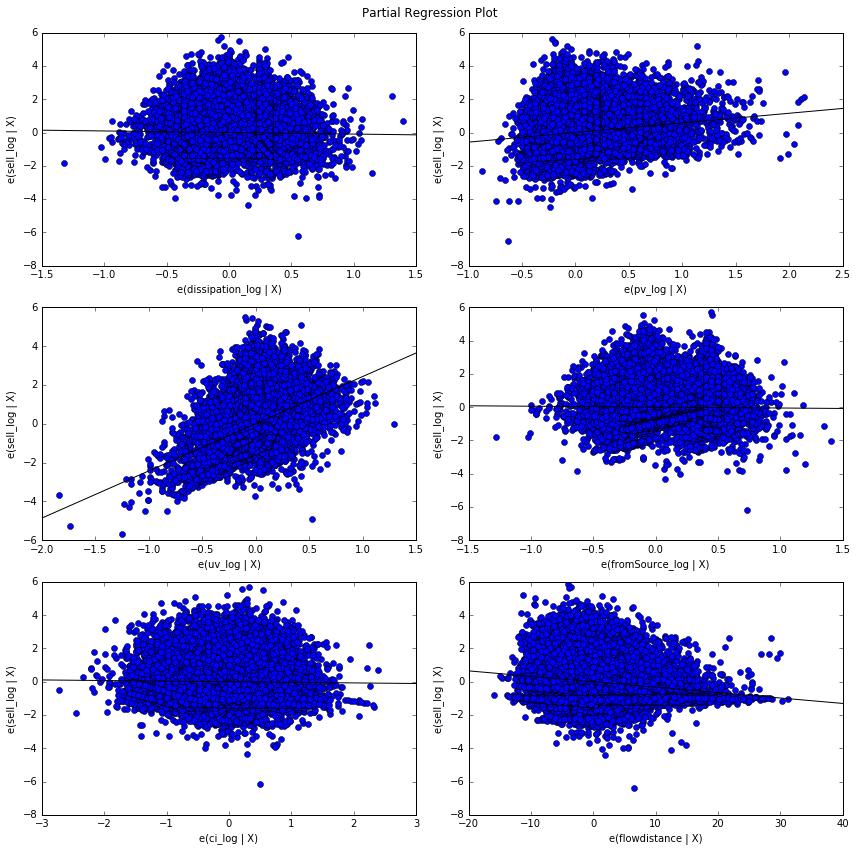

In [64]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,7))
plt.show()

In [39]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)


lm = smf.ols(formula='pv_log ~ dissipation_log + fromSource_log + ci_log + flowdistance', data=diif).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                 pv_log   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Mon, 05 Jun 2017   Prob (F-statistic):               0.00
Time:                        22:45:16   Log-Likelihood:                -5326.3
No. Observations:               30495   AIC:                         1.066e+04
Df Residuals:                   30490   BIC:                         1.070e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.0597      0.005     

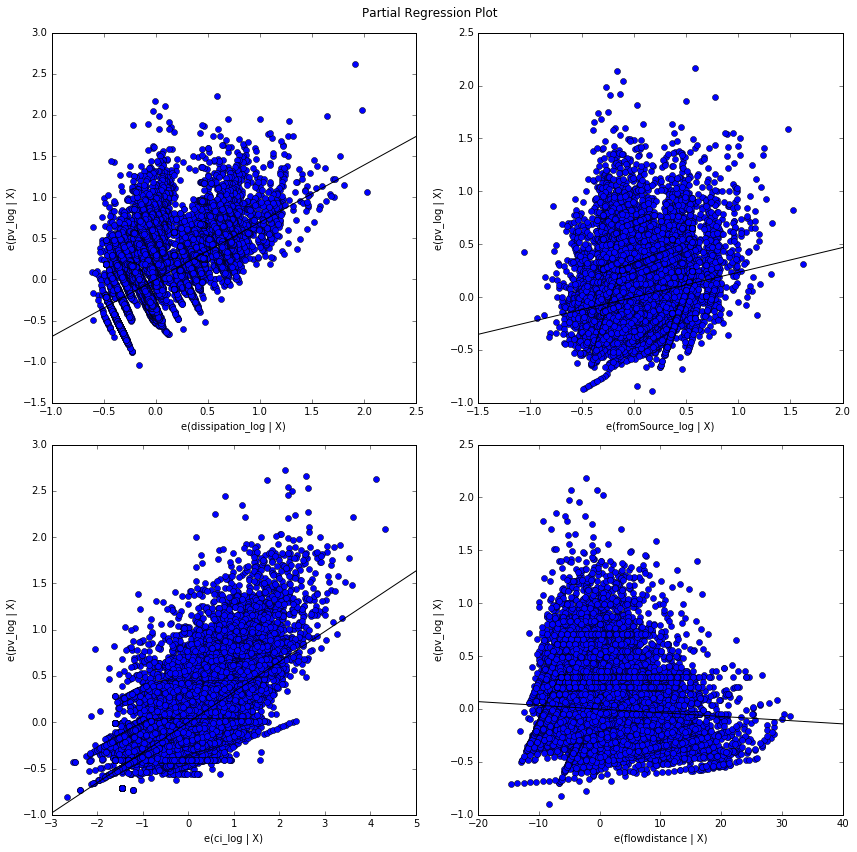

In [40]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,5))
plt.show()

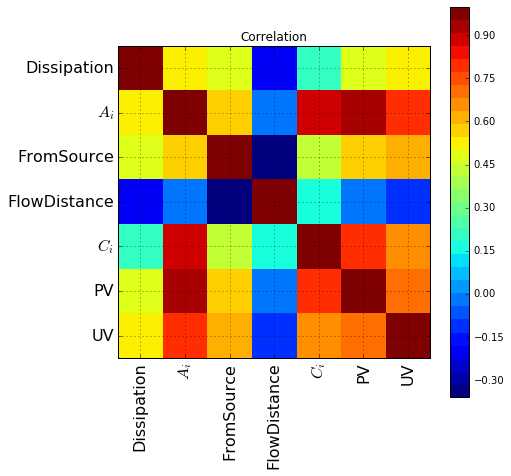

In [33]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(7, 7),facecolor='white')
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation')
    labels=['Dissipation','Dissipation','$A_i$','FromSource','FlowDistance','$C_i$','PV','UV',]
    ax1.set_xticklabels(labels,fontsize=16, rotation = 90)
    ax1.set_yticklabels(labels,fontsize=16)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()

correlation_matrix(diif)

In [25]:
toflow = totalflow-toSink

In [133]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()


## Dissipation Law

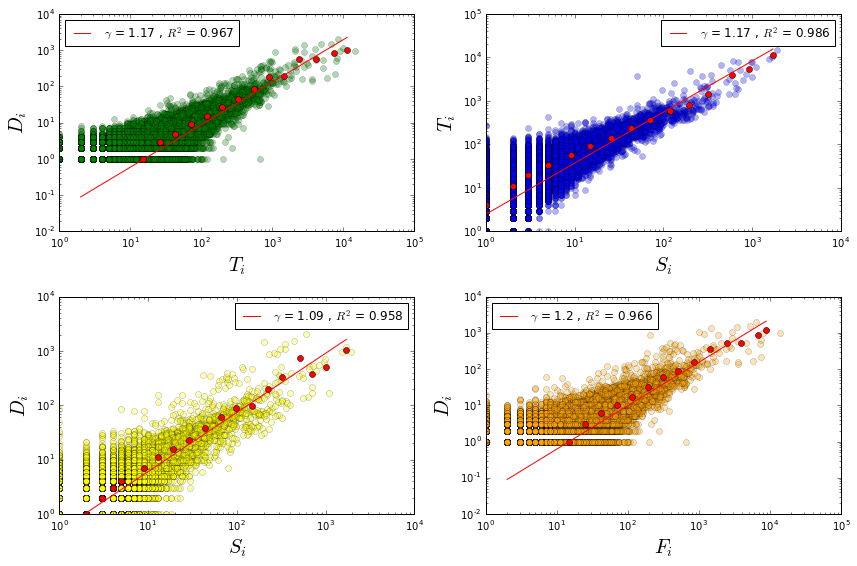

In [144]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$T_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$T_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()


## Allowmetric Growth

In [147]:
taobao_groupby = taobao.groupby('minute')
uv = taobao_groupby['user'].nunique()
pv = taobao_groupby['item'].count()

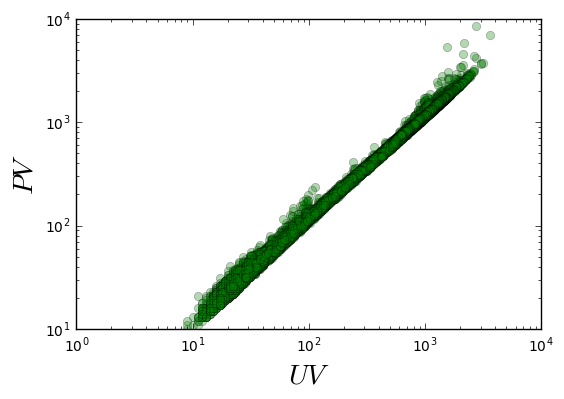

In [125]:
plt.plot(uv, pv, 'go', alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$UV$', fontsize = 20)
plt.ylabel('$PV$', fontsize = 20)

plt.show()

In [153]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, \
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.legend(loc = 0)
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-')

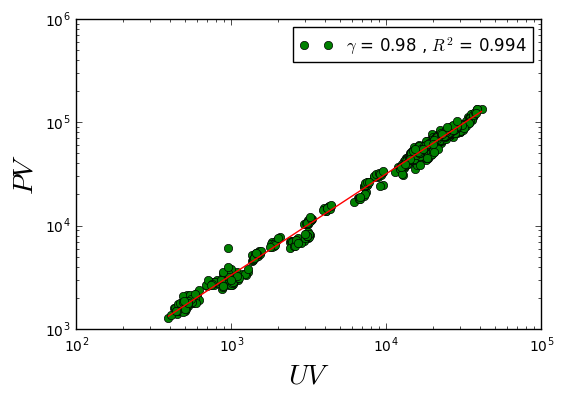

In [149]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

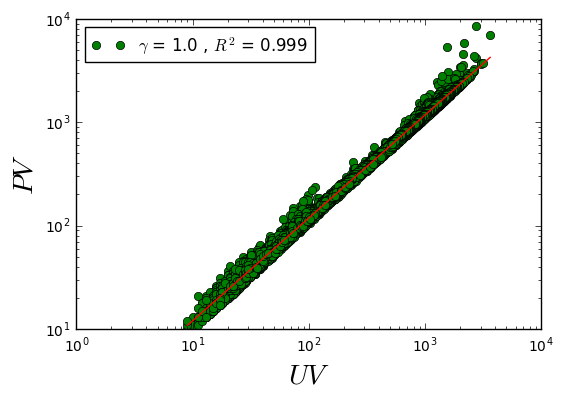

In [140]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

# Purchasing Behaviors

In [47]:
bdf=pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/1Userpurchasetime.csv', 
                names = ['time', 'user', 'item'])

In [48]:
bdf[:3]

,time,user,item
0,0,66195,212085
1,0,270918,3040
2,0,403636,34546


In [49]:
dfi = bdf.groupby(['item']).size()
dfi = dfi.sort_values( ascending= 0)
dfi[:10]

item
3664     3598
3259     3015
1377     1941
884      1939
874      1839
2177     1833
97       1791
3423     1788
23138    1663
1235     1477
dtype: int64

In [52]:
dfi[3664]

3598

In [147]:
bdf['hour'] = [int(i) for i in (bdf.time/3600)]
bdf['minute'] = [int(i) for i in (bdf.time/60)]

bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [148]:
len(bdf)

1465172

In [149]:
bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1]) 

In [151]:
bdf[:20]

,time,user,item,hour,minute
14852,847,1,109,0,14
68425,2322,6,314,0,38
68426,2322,6,367,0,38
68427,2322,6,302,0,38
13369,814,26,1052,0,13
13370,814,26,1032,0,13
13371,814,26,1045,0,13
13372,814,26,1028,0,13
84032,2659,37,1313,0,44
7926,679,38,1377,0,11


In [152]:
bdf_groupby = bdf.groupby('minute')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

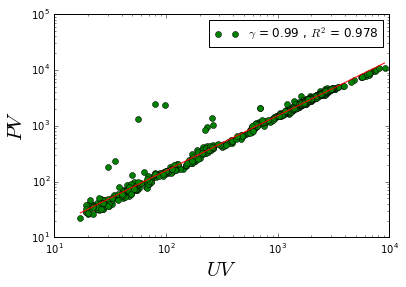

In [154]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

In [155]:
bdf_groupby = bdf.groupby('hour')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

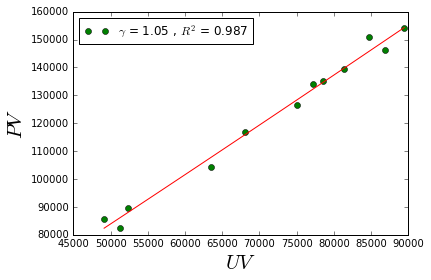

In [157]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', False)